# Demo 2. Network burst inference from raw spike train data
### Richard's comments:
This demo is similar to the previous one, where we aim to do inference with a trained density estimator. But now, we target a real experimental recording. Specifically, we want to discover circuit models that can reproduce a multi-electrode array recording from the organoid dataset (unused in the publication), starting from spike times over 64 electrodes. 

We will walk through how to compute network burst summary statistics such that we can use them for inference, get samples from the trained density estimator, and then simulate and analyze a few of those discovered model configurations to check if they indeed reproduce the target observation.

For more details, visit the [AutoMIND preprint](https://www.biorxiv.org/content/10.1101/2024.08.21.608969v1).

---
Note: to run this notebook live, you will first need to download and unzip the trained DGMs and example dataset. You can find them from the data repository links on the [homepage](https://github.com/mackelab/automind), and you should place them in the appropriate directories by following the included instructions (or simply change the datapaths below).

### My comments: 
This notebook is specifically created for my particular dataset of 10 week develepment and I am looking for best matching 10 discovered models (posterior samples). In this particular one, since it takes a long time to run 10 x 10 simulations, I have put it into a single notebook. The analysis and plotting is done in a separate one. 

In [1]:
# Imports
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

#mpl_rc = "automind/assets/matplotlibrc"
#plt.style.use(mpl_rc)

import os
import numpy as np
import pandas as pd
from time import time
import pickle
from torch import Tensor

import brian2 as b2
from automind.sim import b2_interface, runners
from automind.inference import inferer
from automind.utils import data_utils, analysis_utils, dist_utils, plot_utils
from automind.analysis import spikes_summary

---
# Load trained DGM and meta info, and dataset
We first load the trained deep generative model (Normalizing Flow) stored in the `posterior.pickle` file, along with some analysis parameters we need in `params_dict_analysis_updated.pickle`.

As its name suggests, the posterior file contains the trained posterior estimator neural network, constructed using the `sbi` package. The one we use below is particular to the type of data feature we wish to target, i.e., network burst statistics.

In addition, it contains some meta information, like the specific data features it was trained on---and hence must be passed during inference---as well as data preprocessing steps, which must also be applied to the target observation as well.

Unlike the previous demo, we don't need to load the discovered samples dataset, since we're loading and composing the target data from scratch.

In [2]:
data_dirs = "../automind/datasets/discovered_posterior_samples/organoids/"
path_dict = data_utils.extract_data_files(
    data_dirs,
    [
        "posterior.pickle",
        "params_dict_analysis_updated.pickle",
        "summary_data_merged.csv",
    ],
)
_, posterior, params_dict = data_utils.load_df_posteriors(path_dict)
print(posterior)

cols_features = list(posterior.x_bounds_and_transforms.keys())
print("-------------------------")
print(f'Density estimator was trained on these features: {cols_features}')

posterior.pickle ['5065886_posterior.pickle']
params_dict_analysis_updated.pickle ['5065886_MK1_params_dict_analysis_updated.pickle']
summary_data_merged.csv ['5065886_MK1_summary_data_merged.csv']
2502 samples per xo.
Posterior conditional density p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.
-------------------------
Density estimator was trained on these features: ['burst_interval_mean', 'burst_interval_cv', 'burst_width_mean', 'burst_offset_time_mean']


### Load and process target data from raw spike times
Here, we use another recording from the organoid dataset, and demonstrate how to start from raw spike times to computing summary features amenable to be used for inference.

In [15]:
# Load the list of spike files
spike_files_path = '/nfs/scistore12/gaspgrp/tzuskino/vogels_lab_rotation/figures/data_from_company/M03821_well001/spike_files.txt'
with open(spike_files_path, 'r') as file:
    spike_files = file.read().splitlines()

# Load the spike data from each file
spike_data = []
names_files = []
for i, spike_file in enumerate(spike_files):
    spikes_df = pd.read_parquet(spike_file)
    spike_dict = spikes_df.groupby('Neuron')['Time (s)'].apply(np.array).to_dict()
    spike_data.append(spike_dict)
    names_files.append(os.path.basename(os.path.dirname(os.path.dirname(spike_file))))

# Print the number of recordings loaded
print(f"Loaded {len(spike_data)} recordings.")

Loaded 10 recordings.


Next, we convert the list of spikes into the dictionary form, mimicing the simulated data, in order to use the analysis functions as is. Note that this is not necessary, as any custom processing can be used to analyze the data, as long as its final form is what the trained density estimator expects. Although in practice it's recommended to use the same or similar analysis functions and settings, as this will result in better matches to the simulations.

The convenience function `convert_spike_array_to_dict` creates a dictionary from a list of spike "times" and given a sampling rate, resulting in a dictionary with a population `exc_spikes` and spike times in seconds. Then, we can call the analysis function.

In [20]:
#spikes_dict = data_utils.convert_spike_array_to_dict(spikes_in_list, fs, 'exc_spikes') # 
#spikes_dict['t_end'] = t_end
#spikes_dict['inh_spikes'] = {}

# Analyze data with the same params_dict as the simulated data. 
# Note that depending on your own data, some settings may need to be adjusted in params_dict['params_analysis'].

params_dict['params_analysis']['analysis_window'] = np.array([0.1, None])

spikes_analyzed = []
for i in range(len(spike_data)):
    analyzed_data = analysis_utils.compute_spike_burst_features({'exc_spikes': spike_data[i], 't_end': 200}, params_dict)
    spikes_analyzed.append(analyzed_data)
    print(f'Analysis of recording {i} complete.')

Analysis of recording 0 complete.
Analysis of recording 1 complete.
Analysis of recording 2 complete.
Analysis of recording 3 complete.
Analysis of recording 4 complete.
Analysis of recording 5 complete.
Analysis of recording 6 complete.
Analysis of recording 7 complete.
Analysis of recording 8 complete.
Analysis of recording 9 complete.


This particular analysis computes the total population rate by collapsing across all cells / channels (elements in your original list), and calculates a range of statistics based on the detected network bursts, which uses `scipy.signal.find_peaks` with parameters given by settings in `param_dict`.

We can plot the real data raster and population rate.

### Define target observation data and apply preprocessing
Element 0 of the output contains a dataframe with all the computed statistics. We further focus on just the ones required by the density estimator for inference.

The target observation then has to undergo a few preprocessing steps, in particular, taking the log of the values to be put on the same scale. These transformations are tracked in the posterior network object (`posterior.x_bounds_and_transforms` and `posterior.x_standardizing_func`), and just need to be applied to the dataset.

If you want to run this demo on a new dataset, you just need to replace `df_xos` with your own pandas dataframe, where each row must contain, among other features, the necessary burst timing features (names printed below). 

Alternatively, it can be supplied as a a numpy array (`xo`), where only the last step is necessary (standardizing and converting to torch tensor).

In [21]:
df_xos = spikes_analyzed[0][0]
df_xos[cols_features]

,burst_interval_mean,burst_interval_cv,burst_width_mean,burst_offset_time_mean
0,4.347568,0.451023,0.363287,0.294973


### Adjust some of the recording's burst detection function after some inspection of each one of the samples average pop rate

(   isi_numspks_mu  isi_mean_mu  isi_std_mu  isi_25q_mu  isi_50q_mu  \
0     2160.747308     1.291643    1.921205    0.083648    0.579743   

   isi_75q_mu  isi_cv_mu  isi_numspks_sigma  isi_mean_sigma  isi_std_sigma  \
0    1.751799   2.583861         2106.92972        2.522093       3.037912   

   ...  burst_offset_time_mean  burst_offset_time_std  burst_corr_mean  \
0  ...                1.623407               0.570497         0.850697   

   burst_corr_std  burst_corr_interval2nextpeak  burst_corr_interval2prevpeak  \
0        0.279078                      0.489011                      0.027473   

   burst_numsubpeaks_mean  burst_numsubpeaks_std  burst_mean_fr_mean  \
0                     0.0                    0.0            0.236009   

   burst_mean_fr_std  
0           0.041336  

[1 rows x 34 columns], {'t_ds': array([0.00000e+00, 1.00000e-03, 2.00000e-03, ..., 1.99997e+02,
       1.99998e+02, 1.99999e+02]), 'exc_rate': array([0.83969356, 0.98546057, 1.11944122, ..., 1.8172

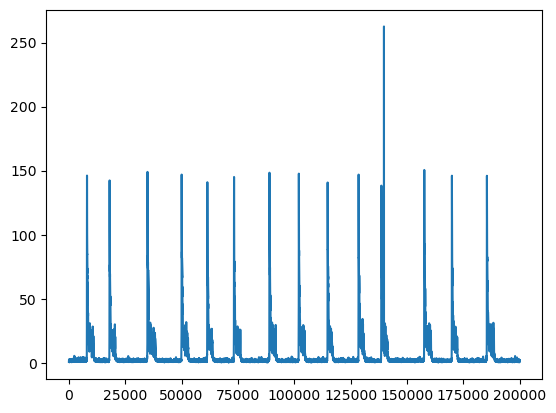

In [ ]:
params_dict_5 = params_dict.copy()
params_dict_5['params_analysis']['min_burst_height_ratio'] = 0.5
spikes_analyzed[5] = analysis_utils.compute_spike_burst_features({'exc_spikes': spike_data[5], 't_end': 200}, params_dict_5)
plt.plot(spikes_analyzed[5][1]['avgpop_rate'])

(   isi_numspks_mu  isi_mean_mu  isi_std_mu  isi_25q_mu  isi_50q_mu  \
0     1425.005831     1.653439    2.458339    0.204922       0.811   

   isi_75q_mu  isi_cv_mu  isi_numspks_sigma  isi_mean_sigma  isi_std_sigma  \
0    2.055052   2.199072         1226.99753        3.152054       3.626168   

   ...  burst_offset_time_mean  burst_offset_time_std  burst_corr_mean  \
0  ...                1.467279               0.465435         0.778041   

   burst_corr_std  burst_corr_interval2nextpeak  burst_corr_interval2prevpeak  \
0         0.26363                     -0.235165                       0.27033   

   burst_numsubpeaks_mean  burst_numsubpeaks_std  burst_mean_fr_mean  \
0                0.133333               0.339935            0.385382   

   burst_mean_fr_std  
0           0.062275  

[1 rows x 34 columns], {'t_ds': array([0.00000e+00, 1.00000e-03, 2.00000e-03, ..., 1.99997e+02,
       1.99998e+02, 1.99999e+02]), 'exc_rate': array([0.5930975 , 0.71816866, 0.84530303, ..., 1.5975

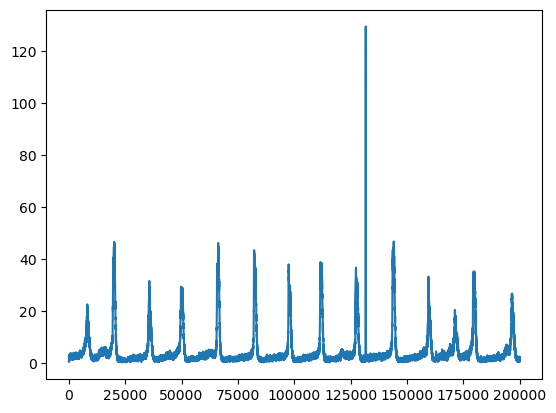

In [ ]:
params_dict_8 = params_dict.copy()
params_dict_8['params_analysis']['min_burst_height_ratio'] = 0.1
spikes_analyzed[8] = analysis_utils.compute_spike_burst_features({'exc_spikes': spike_data[8], 't_end': 200}, params_dict_8)
plt.plot(spikes_analyzed[8][1]['avgpop_rate'])

(   isi_numspks_mu  isi_mean_mu  isi_std_mu  isi_25q_mu  isi_50q_mu  \
0     2076.847969     1.153197    1.822138    0.066242    0.451431   

   isi_75q_mu  isi_cv_mu  isi_numspks_sigma  isi_mean_sigma  isi_std_sigma  \
0    1.630263   2.755696        1972.531018        2.157649       2.692539   

   ...  burst_offset_time_mean  burst_offset_time_std  burst_corr_mean  \
0  ...                3.219225               1.849129          0.68853   

   burst_corr_std  burst_corr_interval2nextpeak  burst_corr_interval2prevpeak  \
0        0.358185                      -0.13986                     -0.566434   

   burst_numsubpeaks_mean  burst_numsubpeaks_std  burst_mean_fr_mean  \
0                     0.0                    0.0            0.304667   

   burst_mean_fr_std  
0           0.089854  

[1 rows x 34 columns], {'t_ds': array([0.00000e+00, 1.00000e-03, 2.00000e-03, ..., 1.99997e+02,
       1.99998e+02, 1.99999e+02]), 'exc_rate': array([0.52649637, 0.63852587, 0.75612977, ..., 1.1109

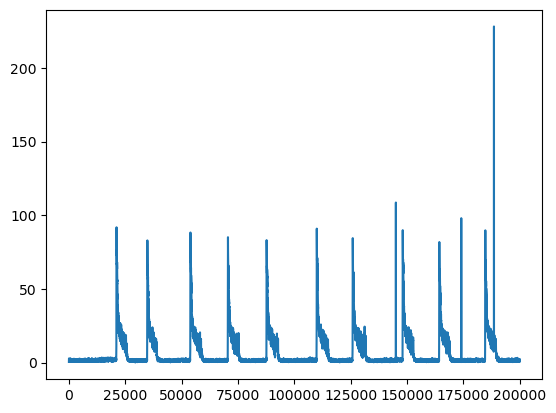

In [52]:
params_dict_9 = params_dict.copy()
params_dict_9['params_analysis']['min_burst_height_ratio'] = 0.2
spikes_analyzed[9] = analysis_utils.compute_spike_burst_features({'exc_spikes': spike_data[9], 't_end': 200}, params_dict_9)
plt.plot(spikes_analyzed[9][1]['avgpop_rate'])

In [65]:
xo_tensor = []
xo = []
for i in range(len(spikes_analyzed)):
    df_xos = spikes_analyzed[i][0]
    df_xos_preproc, _, _, _ = dist_utils.preproc_dataframe(
        df_xos,
        posterior.x_bounds_and_transforms,
        drop_nans=False,
        replace_infs=True,
    )
    xo_i = df_xos_preproc.loc[0][cols_features].values
    xo.append(xo_i)
    xo_tensor_i = posterior.x_standardizing_func(Tensor(xo_i[None, :]))
    xo_tensor.append(xo_tensor_i)
    print(f"Processed target observation has shape {xo_tensor_i.shape}: {xo_tensor_i}")

Processed target observation has shape torch.Size([1, 4]): tensor([[-2.3771,  1.9649, -1.0030, -0.6864]])
Processed target observation has shape torch.Size([1, 4]): tensor([[-2.0727,  1.8041, -0.6283, -0.2747]])
Processed target observation has shape torch.Size([1, 4]): tensor([[-0.7919,  1.8894,  0.7599,  1.2310]])
Processed target observation has shape torch.Size([1, 4]): tensor([[-0.6697,  1.7986,  0.9597,  1.4431]])
Processed target observation has shape torch.Size([1, 4]): tensor([[-0.3300,  1.6856,  0.5726,  1.0477]])
Processed target observation has shape torch.Size([1, 4]): tensor([[-1.0625,  1.3540,  0.2117,  0.6631]])
Processed target observation has shape torch.Size([1, 4]): tensor([[-1.1897,  1.2630,  0.1031,  0.4596]])
Processed target observation has shape torch.Size([1, 4]): tensor([[-1.0217,  1.6368,  0.1235,  0.5512]])
Processed target observation has shape torch.Size([1, 4]): tensor([[-1.0783,  1.5963,  0.7676,  0.5831]])
Processed target observation has shape torch.S

---
# Inference
Same as last time, this is where the magic happens: we provide the (preprocessed) target observation and draw samples of model configurations that are likely to reproduce this target.

Under the hood, the target is supplied as the conditioner to the conditional Normalizing Flow, which then approximates the posterior distribution given that observation, i.e., $p(parameters|target)$.

Also, we apply the "oversampling" trick here: to acquire `n_samples=5` samples in the end, we first sample by a factor of `oversample_factor=200` more (so 1000 total), and then select the top 5 samples with the highest log-likelihood returned by the Normalizing Flow. This is a fast and cheap operation and encourages samples to be in high-density regions, which empirically helps with finding better data-consistent samples.

For real data, we will be taking more final samples (20 here), since there is typically a 5-25% yield of models that actually result in good matches after simulation.

In [54]:
# Set batch and random seeds
batch_seed = 20241121
data_utils.set_all_seeds(batch_seed)

n_samples = 10
cfg_sample = {
    "name": "demo_NPE",
    "oversample_factor": 200,
    "do_sample_map": False,
    "do_sample_pmean": False,
}
df_samples_dict = []
for xo_tensor_i in xo_tensor:
    df_samples, samples_dict = inferer.sample_from_posterior(
        posterior=posterior,  # Posterior network
        prior=posterior,  # Need for extracting bounds
        num_samples=n_samples,  # Number of samples to draw
        x_o=xo_tensor_i,  # Target observation
        cfg_algorithm=cfg_sample,  # Sampling options
    )
    df_samples_dict.append(df_samples)

#df_samples

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

WARNING    /nfs/scistore12/gaspgrp/tzuskino/automind/automind/inference/inferer.py:129: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat((df_to_append_to, df_cur), axis=0)
 [py.warnings]


Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

WARNING    /nfs/scistore12/gaspgrp/tzuskino/automind/automind/inference/inferer.py:129: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat((df_to_append_to, df_cur), axis=0)
 [py.warnings]


Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

WARNING    /nfs/scistore12/gaspgrp/tzuskino/automind/automind/inference/inferer.py:129: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat((df_to_append_to, df_cur), axis=0)
 [py.warnings]


Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

WARNING    /nfs/scistore12/gaspgrp/tzuskino/automind/automind/inference/inferer.py:129: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat((df_to_append_to, df_cur), axis=0)
 [py.warnings]


Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

WARNING    /nfs/scistore12/gaspgrp/tzuskino/automind/automind/inference/inferer.py:129: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat((df_to_append_to, df_cur), axis=0)
 [py.warnings]


Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

WARNING    /nfs/scistore12/gaspgrp/tzuskino/automind/automind/inference/inferer.py:129: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat((df_to_append_to, df_cur), axis=0)
 [py.warnings]


Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

WARNING    /nfs/scistore12/gaspgrp/tzuskino/automind/automind/inference/inferer.py:129: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat((df_to_append_to, df_cur), axis=0)
 [py.warnings]


Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

WARNING    /nfs/scistore12/gaspgrp/tzuskino/automind/automind/inference/inferer.py:129: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat((df_to_append_to, df_cur), axis=0)
 [py.warnings]


Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

WARNING    /nfs/scistore12/gaspgrp/tzuskino/automind/automind/inference/inferer.py:129: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat((df_to_append_to, df_cur), axis=0)
 [py.warnings]


Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

WARNING    /nfs/scistore12/gaspgrp/tzuskino/automind/automind/inference/inferer.py:129: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat((df_to_append_to, df_cur), axis=0)
 [py.warnings]


---
# Simulate discovered configurations
Now, we can take those model parameter configurations and simulate them using the clustered AdEx spiking neural network, saving the spike train data and some meta-info.

For the purpose of the demo, we run the simulations in the notebook. However, this does take a long time, especially when multiprocessing doesn't place nice with Jupyter, i.e., as reported for Mac and Windows. Practically, this step is done on a compute cluster, and is highly parallelizeable (1 cpu per simulation). 

In [125]:
# Some housekeeping to set random seed identifiers and set up simulation configurations
# params_dict['params_settings']['batch_seed'] = batch_seed
params_dict_run = {}
for i, df_samples in enumerate(df_samples_dict):
    random_seeds = np.sort(
        np.random.choice(a=int(n_samples * 100), size=n_samples, replace=False)
    )
    df_samples_dict[i].insert(loc=0, column="params_settings.batch_seed", value=batch_seed)
    df_samples_dict[i].insert(loc=1, column="params_settings.random_seed", value=random_seeds)

    # NOTE: This sets the correct early-stopping condition, i.e., to assess the simulation from 0.1 to 10.1 seconds.
    params_dict['params_analysis']['analysis_window'] = [0.1, None] 

    params_dict_run[i] = data_utils.fill_params_dict(
        params_dict, df_samples_dict[i], posterior.as_dict, n_samples
    )

ValueError: cannot insert params_settings.batch_seed, already exists

In [63]:
cache_path = "./.cache/"
b2_interface.clear_b2_cache(cache_path)
b2_interface.set_b2_cache(cache_path, True)

sim_parallel = True
if sim_parallel:
    from multiprocessing import Pool

    start_time = time()
    sim_collector = {}
    for i in range(len(params_dict_run)):
        with Pool(n_samples) as pool:
            sim_collector[i] = pool.map(runners.adex_simulator, params_dict_run[i])
        print(f"Simulations took {time()-start_time:.2f} seconds.")
else:
    sim_collector = []
    for i_sim in range(n_samples):
        start_time = time()
        sim_collector.append(runners.adex_simulator(params_dict_run[i_sim]))
        print(f"Simulation {i_sim+1}/{n_samples} took {time()-start_time:.2f} seconds.")

b2_interface.clear_b2_cache(cache_path)

cache non-existent.


20241121-18120241121-777|20241121-28520241121-333||20241121-62820241121-742||20241121-855|20241121-890||20241121-893|20241121-944|

WARNING    Epop's variable 'w' has NaN, very large values, or encountered an error in numerical integration. This is usually a sign that an unstable or invalid integration method was chosen. [brian2.groups.group.invalid_values]
WARNING    Epop's variable 'v' has NaN, very large values, or encountered an error in numerical integration. This is usually a sign that an unstable or invalid integration method was chosen. [brian2.groups.group.invalid_values]


Simulations took 437.47 seconds.
20241121-98|20241121-25320241121-243|20241121-38620241121-371|20241121-46520241121-506||||20241121-56120241121-67620241121-744|||Simulations took 716.61 seconds.
20241121-28|20241121-49320241121-9120241121-70720241121-49620241121-49020241121-369||||||20241121-87020241121-91520241121-931|||Simulations took 1014.45 seconds.
20241121-9920241121-31220241121-9620241121-515|20241121-49420241121-75320241121-95520241121-85820241121-761|||20241121-978||||||Simulations took 1413.21 seconds.
20241121-7320241121-180|20241121-71020241121-43020241121-84320241121-28020241121-43920241121-62520241121-62120241121-868|||||||||Simulations took 1752.82 seconds.
20241121-3420241121-7|20241121-76520241121-33320241121-75620241121-149|20241121-86320241121-431|20241121-12020241121-589|||||||Simulations took 2050.12 seconds.
20241121-26820241121-23920241121-44020241121-53220241121-74020241121-49820241121-70720241121-982||20241121-887|||20241121-910|||||Simulations took 2354.29 se

### Compute summary features
From the simulation data (spike trains), we can analyze them and extract the same bursting features, as well as smoothed population firing rate over time.

In [84]:
results_collector = {}
for i in range(len(params_dict_run)):
    results_collector[i] = [
        analysis_utils.compute_summary_features(sims[1], sims[0]) for sims in sim_collector[i]
    ]

WARNING    /nfs/scistore12/gaspgrp/tzuskino/automind/automind/analysis/spikes_summary.py:601: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  "burst_corr_interval2nextpeak": stats.spearmanr(
 [py.warnings]
WARNING    /nfs/scistore12/gaspgrp/tzuskino/automind/automind/analysis/spikes_summary.py:604: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  "burst_corr_interval2prevpeak": stats.spearmanr(
 [py.warnings]
WARNING    /nfs/scistore12/gaspgrp/tzuskino/miniforge3/envs/automind/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
 [py.warnings]
WARNING    /nfs/scistore12/gaspgrp/tzuskino/automind/automind/analysis/spikes_summary.py:601: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  "burst_corr_interval2nextpeak": stats.spearmanr(
 [py.warnings]
WARNING    

### Plot the discovered model simulations
Finally, we plot the simulated spike trains and the population firing rate of each discovered model. 

Note that we will first re-order the simulations based on their similarity to the real data (to show the best models first). We will plot the real data to the right for comparison.

In [100]:
model_stats = np.ones((n_samples, len(cols_features))) * np.inf
for i_sim, rc in enumerate(results_collector[0]):
    print(rc['summary_bursts'])
    if not rc['summary_bursts'][cols_features].empty:
        model_stats[i_sim, :] = rc['summary_bursts'][cols_features].values

   burst_num  burst_interval_mean  burst_interval_std  burst_interval_cv  \
0        290             0.692287            0.151408           0.218707   

   burst_peak_fr_mean  burst_peak_fr_std  burst_width_mean  burst_width_std  \
0           13.462065           1.508097           0.75014         1.048888   

   burst_onset_time_mean  burst_onset_time_std  burst_offset_time_mean  \
0               0.418394              0.789182                0.331746   

   burst_offset_time_std  burst_corr_mean  burst_corr_std  \
0               0.498429         0.020945        0.048063   

   burst_corr_interval2nextpeak  burst_corr_interval2prevpeak  \
0                      0.205997                       0.02309   

   burst_numsubpeaks_mean  burst_numsubpeaks_std  burst_mean_fr_mean  \
0                     4.1               6.517377            0.562939   

   burst_mean_fr_std  
0            0.07093  
Empty DataFrame
Columns: [burst_num, burst_interval_mean, burst_interval_std, burst_interval_c

In [101]:
ordered = {}
for i in range(len(params_dict_run)):    
    model_stats = np.ones((n_samples, len(cols_features))) * np.inf
    for i_sim, rc in enumerate(results_collector[i]):
        if not rc['summary_bursts'][cols_features].empty:
            model_stats[i_sim, :] = rc['summary_bursts'][cols_features].values

    ordered[i] = np.argsort(np.abs(np.log10(model_stats) - xo[i]).sum(axis=1))

WARNING    /tmp/ipykernel_2553933/1849124177.py:8: RuntimeWarning: divide by zero encountered in log10
  ordered[i] = np.argsort(np.abs(np.log10(model_stats) - xo[i]).sum(axis=1))
 [py.warnings]


In [102]:
ordered

{0: array([3, 8, 0, 7, 6, 9, 5, 2, 4, 1]),
 1: array([5, 0, 9, 2, 4, 3, 6, 1, 7, 8]),
 2: array([9, 8, 1, 0, 4, 5, 2, 3, 7, 6]),
 3: array([5, 0, 2, 1, 3, 4, 6, 7, 8, 9]),
 4: array([6, 0, 5, 1, 3, 2, 4, 7, 8, 9]),
 5: array([9, 1, 6, 2, 3, 4, 5, 0, 7, 8]),
 6: array([6, 2, 1, 0, 3, 4, 5, 7, 8, 9]),
 7: array([8, 1, 3, 7, 2, 4, 5, 0, 6, 9]),
 8: array([3, 2, 7, 9, 5, 1, 0, 6, 4, 8]),
 9: array([7, 1, 3, 8, 4, 2, 5, 0, 6, 9])}

### Save the data to be plotted later

In [ ]:
with open('sim_collector.pickle', 'wb') as f:
    pickle.dump(sim_collector, f)

with open('ordered.pickle', 'wb') as f:
    pickle.dump(ordered, f)